In [ ]:
# Standard library imports
import os
import re
import time
import string
import locale

# Locale settings
def getpreferredencoding(do_setlocale=True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# Package installations
!pip install openpyxl
!pip install --upgrade xlsxwriter
!pip install bertopic
!pip install flair
!apt-get -qq install -y libfluidsynth1

# NLP related imports and initializations
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.util import ngrams
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
wn = nltk.WordNetLemmatizer()

# Machine learning and clustering imports
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from transformers.pipelines import pipeline
from hdbscan import hdbscan

# Topic modeling
from bertopic import BERTopic

# Embeddings
from flair.embeddings import (
    TransformerDocumentEmbeddings,
    WordEmbeddings,
    DocumentPoolEmbeddings,
    StackedEmbeddings
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 64.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TOPIC MODELLING/clean_politics_data.csv')
df

,Clean_Title,Clean_Body,Clean_Comments
0,pdp g5 govs return river uk meeting,g5 governor popularly known integrity group wi...,keep wasting tax payer money flying hokumhave ...
1,onslaught launched killerherdsmen southwest,amotekun comb ondo forest ogun buy drone monit...,cant killing people god given natural resource...
2,unfair immoral unjust northerner succeed buhar...,shettima arewa youth consultative forum presid...,time waste vote stay alive time come waste vot...
3,10 political blunder made nigerian presidentia...,among many gaffe made top political office con...,time waste vote stay alive time come waste vot...
4,equity demand presidency go north pdp senator ...,lawmaker representing akwa ibom northwest sena...,well spoken like true slavewe know pocket your...
...,...,...,...
82197,boko haram made money fuel subsidy,fellow nigerian bokoharam able purchase weapon...,size20ptyou foolsizethe man saying truth u che...
82198,iweala imfworld bank agent vow resign gej retu...,untrue threatened resign serving dear country ...,please madam resign fast since got thing gone ...
82199,minister labour using scare tactic,watched minister labour ait stern faced tellin...,dont mind animal let come meet people streetst...
82200,1600 bus deployed nation wide,gej coming fec meeting promised 1600 bus natio...,fresh bus hahahato managed federal statecontra...


In [ ]:
import urllib

def clean_text(data):
    if pd.isna(data):
        return ""

    data = str(data)  # Convert data to string

    data = data.lower()

    # Remove punctuations, HTML tags, URLs, and emojis
    punct_tag = re.compile(r'[^\w\s]')
    html_tag = re.compile(r'<.*?>')
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)

    data = punct_tag.sub(r'', data)
    data = html_tag.sub(r'', data)
    data = ' '.join([word for word in data.split() if not (urllib.parse.urlsplit(word).scheme or word.startswith('www.'))])
    data = emoji_clean.sub(r'', data)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = data.split()
    data = ' '.join([word for word in words if word.lower() not in stop_words])

    # Lemmatization
    wn = WordNetLemmatizer()
    lemmatized_words = [wn.lemmatize(w) for w in words]
    data = ' '.join(lemmatized_words)

    return data

In [ ]:
data = df.applymap(clean_text)
data

,Clean_Title,Clean_Body,Clean_Comments
0,pdp g5 govs return river uk meeting,g5 governor popularly known integrity group wi...,keep wasting tax payer money flying hokumhave ...
1,onslaught launched killerherdsmen southwest,amotekun comb ondo forest ogun buy drone monit...,cant killing people god given natural resource...
2,unfair immoral unjust northerner succeed buhar...,shettima arewa youth consultative forum presid...,time waste vote stay alive time come waste vot...
3,10 political blunder made nigerian presidentia...,among many gaffe made top political office con...,time waste vote stay alive time come waste vot...
4,equity demand presidency go north pdp senator ...,lawmaker representing akwa ibom northwest sena...,well spoken like true slavewe know pocket your...
...,...,...,...
82197,boko haram made money fuel subsidy,fellow nigerian bokoharam able purchase weapon...,size20ptyou foolsizethe man saying truth u che...
82198,iweala imfworld bank agent vow resign gej retu...,untrue threatened resign serving dear country ...,please madam resign fast since got thing gone ...
82199,minister labour using scare tactic,watched minister labour ait stern faced tellin...,dont mind animal let come meet people streetst...
82200,1600 bus deployed nation wide,gej coming fec meeting promised 1600 bus natio...,fresh bus hahahato managed federal statecontra...


In [ ]:
data['Title+Body'] = data['Clean_Title'] + '' + data['Clean_Body']
data

,Clean_Title,Clean_Body,Clean_Comments,Title+Body
0,pdp g5 govs return river uk meeting,g5 governor popularly known integrity group wi...,keep wasting tax payer money flying hokumhave ...,pdp g5 govs return river uk meetingg5 governor...
1,onslaught launched killerherdsmen southwest,amotekun comb ondo forest ogun buy drone monit...,cant killing people god given natural resource...,onslaught launched killerherdsmen southwestamo...
2,unfair immoral unjust northerner succeed buhar...,shettima arewa youth consultative forum presid...,time waste vote stay alive time come waste vot...,unfair immoral unjust northerner succeed buhar...
3,10 political blunder made nigerian presidentia...,among many gaffe made top political office con...,time waste vote stay alive time come waste vot...,10 political blunder made nigerian presidentia...
4,equity demand presidency go north pdp senator ...,lawmaker representing akwa ibom northwest sena...,well spoken like true slavewe know pocket your...,equity demand presidency go north pdp senator ...
...,...,...,...,...
82197,boko haram made money fuel subsidy,fellow nigerian bokoharam able purchase weapon...,size20ptyou foolsizethe man saying truth u che...,boko haram made money fuel subsidyfellow niger...
82198,iweala imfworld bank agent vow resign gej retu...,untrue threatened resign serving dear country ...,please madam resign fast since got thing gone ...,iweala imfworld bank agent vow resign gej retu...
82199,minister labour using scare tactic,watched minister labour ait stern faced tellin...,dont mind animal let come meet people streetst...,minister labour using scare tacticwatched mini...
82200,1600 bus deployed nation wide,gej coming fec meeting promised 1600 bus natio...,fresh bus hahahato managed federal statecontra...,1600 bus deployed nation widegej coming fec me...


### Function to plot WordCloud

In [ ]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()


### WordCloud of News Titles

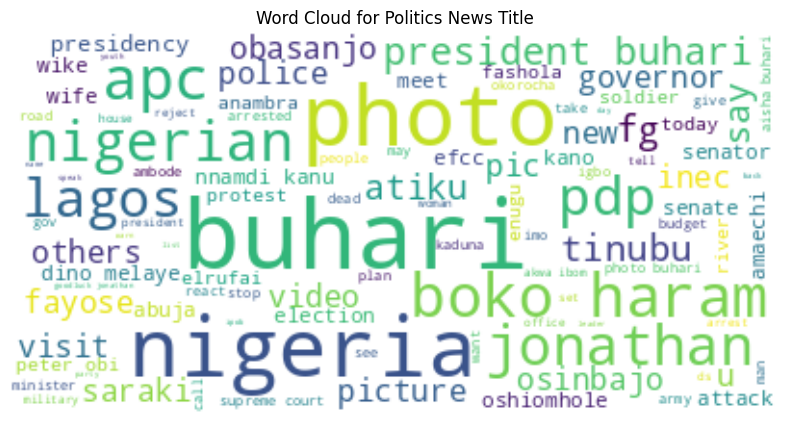

In [ ]:
all_title = ' '.join(data['Clean_Title'].astype(str))
plot_wordcloud(all_title, 'Word Cloud for Politics News Title')

### WordCloud of News Body

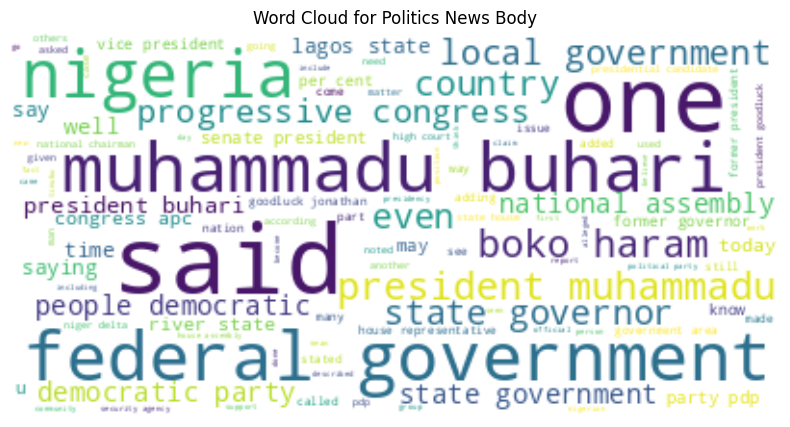

In [ ]:
all_body = ' '.join(data['Clean_Body'].astype(str))
plot_wordcloud(all_body, 'Word Cloud for Politics News Body')

### WordCloud of Comments

In [ ]:
# Commented out to preserve memory
# all_comment = ' '.join(data['Clean_Comments'].astype(str))
# plot_wordcloud(all_comment, 'Word Cloud for Politics News Comments')

### Defining N-Grams

In [ ]:
# Function to tokenize the text
def tokenize(text):
    return text.split()

# Tokenize the text
all_title_words = tokenize(all_title)

# Generate n-grams
unigrams = list(ngrams(all_title_words, 1))
bigrams = list(ngrams(all_title_words, 2))
trigrams = list(ngrams(all_title_words, 3))

# Count the frequency of each n-gram
freq_unigrams = FreqDist(unigrams)
freq_bigrams = FreqDist(bigrams)
freq_trigrams = FreqDist(trigrams)

# Extract the top 10 n-grams
top_unigrams = freq_unigrams.most_common(10)
top_bigrams = freq_bigrams.most_common(10)
top_trigrams = freq_trigrams.most_common(10)

# Function to plot the bar chart
def plot_bar_chart(ngrams, title):
    ngram, freq = zip(*ngrams)
    ngram = [' '.join(item) for item in ngram]
    colors = plt.cm.viridis(np.linspace(0, 1, 10))  # create a color map
    plt.figure(figsize=(10, 5))
    plt.barh(ngram, freq, color=colors)  # plot horizontal bar chart with different colors
    plt.xlabel('Frequency')
    plt.title(title)
    plt.show()



### Top 10 Unigrams

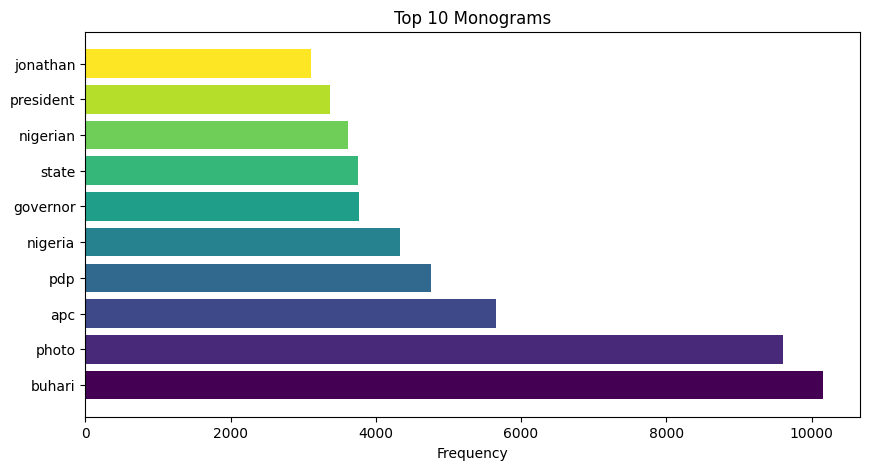

In [ ]:
plot_bar_chart(top_unigrams, 'Top 10 Unigrams')

### Top 10 Bigrams

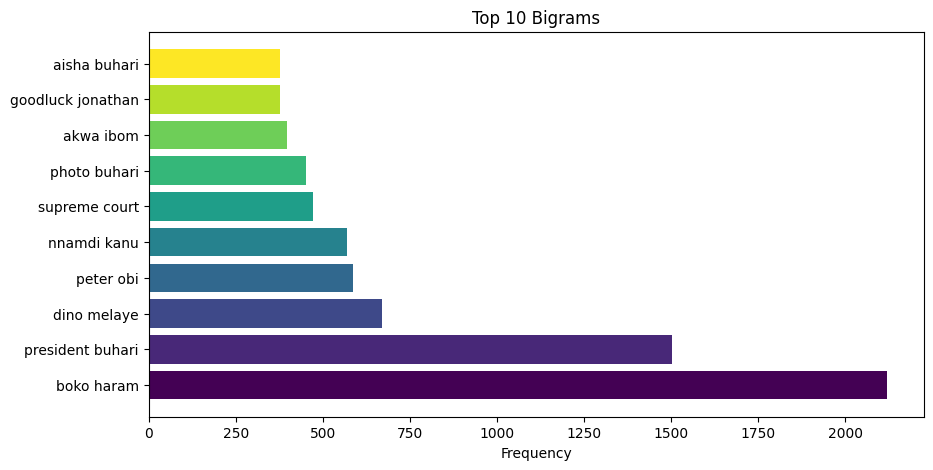

In [ ]:
plot_bar_chart(top_bigrams, 'Top 10 Bigrams')

### Top Trigrams

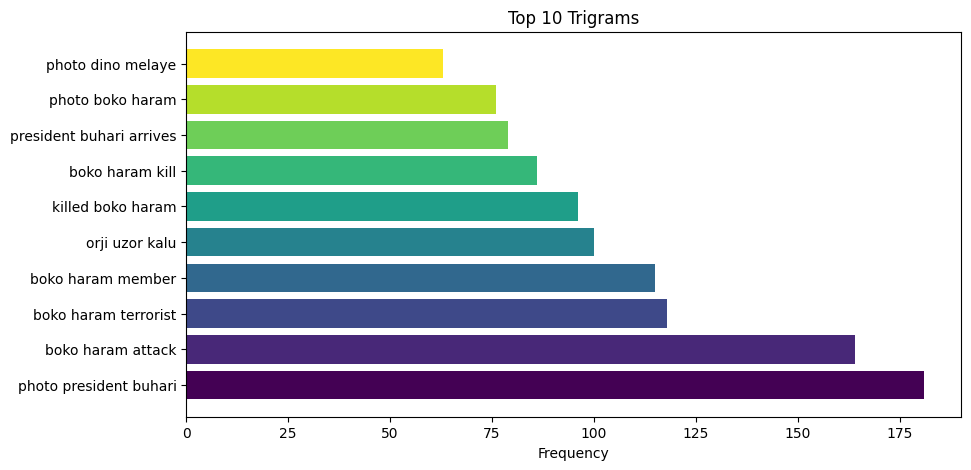

In [ ]:
plot_bar_chart(top_trigrams, 'Top 10 Trigrams')

In [ ]:
import time
clusters = 10
# Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)
# Clustering model
kmeans_model = KMeans(n_clusters=clusters)
# Initiate a sentence transformer model
sentence_model = SentenceTransformer("paraphrase-albert-small-v2")
# Initiate a pretrained model
hf_model = pipeline("feature-extraction", model="distilroberta-base")

# Initiate a pretrained embedding model
roberta_model = TransformerDocumentEmbeddings('roberta-base')
# Initiate another pretrained embedding model
glove_embedding = WordEmbeddings('crawl')
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])
# Stack the two pretrained embedding models
stacked_embeddings = StackedEmbeddings(embeddings=[roberta_model,
document_glove_embeddings])

# Count vectorizer
vectorizer_model = CountVectorizer(min_df=10)

# Initiate BERTopic
topic_model10 = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True,hdbscan_model=kmeans_model, n_gram_range=(1, 3))



Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2023-05-03 16:05:47,295 https://flair.informatik.hu-berlin.de/resources/embeddings/token/en-fasttext-crawl-300d-1M.vectors.npy not found in cache, downloading to /tmp/tmpna3gw_11



  0%|          | 0.00/1.12G [00:00<?, ?B/s]
  0%|          | 16.0k/1.12G [00:00<2:02:16, 164kB/s]
  0%|          | 47.0k/1.12G [00:00<1:22:57, 241kB/s]
  0%|          | 117k/1.12G [00:00<45:57, 435kB/s]   
  0%|          | 250k/1.12G [00:00<26:16, 761kB/s]
  0%|          | 516k/1.12G [00:00<14:19, 1.40MB/s]
  0%|          | 1.04M/1.12G [00:00<07:35, 2.63MB/s]
  0%|          | 2.08M/1.12G [00:00<03:57, 5.05MB/s]
  0%|          | 4.17M/1.12G [00:00<02:01, 9.81MB/s]
  1%|          | 6.77M/1.12G [00:00<01:21, 14.6MB/s]
  1%|          | 9.51M/1.12G [00:01<01:05, 18.2MB/s]
  1%|          | 12.0M/1.12G [00:01<00:58, 20.4MB/s]
  1%|▏         | 14.6M/1.12G [00:01<00:52, 22.5MB/s]
  1%|▏         | 16.8M/1.12G [00:01<00:55, 21.4MB/s]
  2%|▏         | 19.4M/1.12G [00:01<00:50, 23.1MB/s]
  2%|▏         | 22.1M/1.12G [00:01<00:47, 24.7MB/s]
  2%|▏         | 24.7M/1.12G [00:01<00:46, 25.5MB/s]
  2%|▏         | 27.2M/1.12G [00:01<00:47, 24.8MB/s]
  3%|▎         | 29.8M/1.12G [00:01<00:47, 24.6MB/s]
 

2023-05-03 16:06:35,230 copying /tmp/tmpna3gw_11 to cache at /root/.flair/embeddings/en-fasttext-crawl-300d-1M.vectors.npy


2023-05-03 16:06:39,567 removing temp file /tmp/tmpna3gw_11
2023-05-03 16:06:40,367 https://flair.informatik.hu-berlin.de/resources/embeddings/token/en-fasttext-crawl-300d-1M not found in cache, downloading to /tmp/tmph7n3ty4j



  0%|          | 0.00/37.5M [00:00<?, ?B/s]
  0%|          | 8.00k/37.5M [00:00<11:28, 57.1kB/s]
  0%|          | 31.0k/37.5M [00:00<04:41, 140kB/s] 
  0%|          | 78.0k/37.5M [00:00<02:26, 269kB/s]
  0%|          | 109k/37.5M [00:00<02:21, 277kB/s] 
  1%|          | 219k/37.5M [00:00<01:12, 543kB/s]
  1%|          | 461k/37.5M [00:00<00:34, 1.12MB/s]
  2%|▏         | 953k/37.5M [00:00<00:17, 2.25MB/s]
  5%|▌         | 1.88M/37.5M [00:00<00:08, 4.42MB/s]
 10%|█         | 3.78M/37.5M [00:01<00:04, 8.74MB/s]
 15%|█▌        | 5.79M/37.5M [00:01<00:02, 12.0MB/s]
 21%|██        | 7.74M/37.5M [00:01<00:02, 14.1MB/s]
 26%|██▌       | 9.74M/37.5M [00:01<00:01, 15.6MB/s]
 34%|███▍      | 12.7M/37.5M [00:01<00:01, 19.9MB/s]
 39%|███▉      | 14.6M/37.5M [00:01<00:01, 15.6MB/s]
 46%|████▋     | 17.4M/37.5M [00:01<00:01, 18.9MB/s]
 52%|█████▏    | 19.4M/37.5M [00:01<00:00, 19.5MB/s]
 57%|█████▋    | 21.4M/37.5M [00:01<00:00, 17.7MB/s]
 62%|██████▏   | 23.3M/37.5M [00:02<00:00, 18.3MB/s]
 70%|██

2023-05-03 16:06:43,571 copying /tmp/tmph7n3ty4j to cache at /root/.flair/embeddings/en-fasttext-crawl-300d-1M
2023-05-03 16:06:43,615 removing temp file /tmp/tmph7n3ty4j


In [ ]:
# Start the timer
start_time = time.time()

# Run BERTopic model
topics, probabilities = topic_model10.fit_transform(data['Title+Body'])

# Stop the timer
end_time = time.time()

In [ ]:
time_taken_10c = end_time - start_time
# Print the time taken
print(f"Time taken to train the topic modeling model: {time_taken_10c} seconds")

Time taken to train the topic modeling model: 7339.095753192902 seconds


In [ ]:
# Get the list of topics
topic_model10.get_topic_info()

,Topic,Count,Name
0,0,13693,0_president_buhari_nigeria_said
1,1,12798,1_party_apc_pdp_election
2,2,8635,2_police_state_said_government
3,3,7937,3_boko_haram_boko haram_said
4,4,7574,4_buhari_president_state_photo
5,5,7287,5_court_said_efcc_mr
6,6,7236,6_government_said_state_oil
7,7,6579,7_state_governor_party_said
8,8,5315,8_state_wife_governor_woman
9,9,5148,9_state_road_government_said


In [ ]:
num_topics = len(topic_model10.get_topic_info())
for i in range(num_topics):
    print(f"Topic {i}:")
    terms = topic_model10.get_topic(i)
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")
    print()

Topic 0:
  president: 0.0174
  buhari: 0.0123
  nigeria: 0.0113
  said: 0.0100
  nigerian: 0.0098
  people: 0.0086
  country: 0.0080
  state: 0.0077
  government: 0.0070
  would: 0.0066

Topic 1:
  party: 0.0247
  apc: 0.0171
  pdp: 0.0166
  election: 0.0144
  state: 0.0141
  national: 0.0119
  said: 0.0114
  governor: 0.0097
  candidate: 0.0083
  member: 0.0081

Topic 2:
  police: 0.0140
  state: 0.0128
  said: 0.0112
  government: 0.0089
  security: 0.0086
  people: 0.0083
  nigeria: 0.0082
  nigerian: 0.0074
  ipob: 0.0059
  also: 0.0058

Topic 3:
  boko: 0.0162
  haram: 0.0155
  boko haram: 0.0149
  said: 0.0132
  state: 0.0123
  attack: 0.0093
  government: 0.0088
  security: 0.0085
  army: 0.0083
  military: 0.0083

Topic 4:
  buhari: 0.0262
  president: 0.0260
  state: 0.0169
  photo: 0.0135
  governor: 0.0119
  visit: 0.0103
  meeting: 0.0089
  president buhari: 0.0088
  muhammadu: 0.0087
  presidential: 0.0087

Topic 5:
  court: 0.0154
  said: 0.0115
  efcc: 0.0113
  mr: 0.009

In [ ]:
# Get the list of topics
topic_model10.get_topic_info()

,Topic,Count,Name
0,0,13693,0_president_buhari_nigeria_said
1,1,12798,1_party_apc_pdp_election
2,2,8635,2_police_state_said_government
3,3,7937,3_boko_haram_boko haram_said
4,4,7574,4_buhari_president_state_photo
5,5,7287,5_court_said_efcc_mr
6,6,7236,6_government_said_state_oil
7,7,6579,7_state_governor_party_said
8,8,5315,8_state_wife_governor_woman
9,9,5148,9_state_road_government_said


In [ ]:
# Visualize top topic keywords
topic_model10.visualize_barchart(top_n_topics=10)

In [ ]:
# Visualize intertopic distance
topic_model10.visualize_topics()

In [ ]:
# Visualize similarity using heatmap
topic_model10.visualize_heatmap()

In [ ]:
# Save the topic model
topic_model10.save("/content/drive/MyDrive/TOPIC MODELLING/Politics_10_Clusters")
# Load the topic model
#my_model1 = BERTopic.load("/content/drive/MyDrive/TOPIC MODELLING/Politics_10_Clusters")

In [ ]:
my_model1 = BERTopic.load("/content/drive/MyDrive/TOPIC MODELLING/Politics_10_Clusters")

In [ ]:
# New data for the review
new_review = '''
Tinubu Delighted With Rousing Welcome In Port Harcourt (photos) by chokekachy:
"I was delighted by the rousing welcome I received upon my arrival in Port Harcourt earlier today.
It was an honour to have been invited by His Excellency, Governor Nyesom Ezenwa Wike, to commission
the latest of the many wonderful developmental projects executed by his administration."
'''
# Find topics
num_of_topics = 3
similar_topics, similarity = my_model1.find_topics(new_review, top_n=num_of_topics);
# Print results
print(f'The top {num_of_topics} similar topics are {similar_topics}, and the similarities are {np.round(similarity,2)}')

The top 3 similar topics are [6, 11, 9], and the similarities are [0.6  0.53 0.5 ]


# DELETE THE CELL BELOW

In [ ]:
# Load the topic model
topic_model10 = BERTopic.load("/content/drive/MyDrive/TOPIC MODELLING/Politics_10_Clusters")
# New data for the review
new_review = '''
Tinubu Delighted With Rousing Welcome In Port Harcourt (photos) by chokekachy:
"I was delighted by the rousing welcome I received upon my arrival in Port Harcourt earlier today.
It was an honour to have been invited by His Excellency, Governor Nyesom Ezenwa Wike, to commission
the latest of the many wonderful developmental projects executed by his administration."
'''
# Find topics
num_of_topics = 3
similar_topics, similarity = topic_model10.find_topics(new_review, top_n=num_of_topics);
# Print results
print(f'The top {num_of_topics} similar topics are {similar_topics}, and the similarities are {np.round(similarity,2)}')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/bertopic/_bertopic.py:3005 in load                       │
│                                                                                                  │
│   3002 │   │   if file_or_dir.is_dir():                                                          │
│   3003 │   │   │   topics, params, tensors, ctfidf_tensors, ctfidf_config, images = save_utils.  │
│   3004 │   │   elif "/" in str(path):                                                            │
│ ❱ 3005 │   │   │   topics, params, tensors, ctfidf_tensors, ctfidf_config, images = save_utils.  │
│   3006 │   │   else:                                                                             │
│   3007 │   │   │   raise ValueError("Make sure to either pass a valid directory or HF model.")   │
│   3008 │   │   topic_model = _create_model_from_files(topics, params, tensors, ctfidf_tensors,   │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/bertopic/_save_utils.py:216 in load_files_from_hf        │
│                                                                                                  │
│   213 │   path = str(path)                                                                       │
│   214 │                                                                                          │
│   215 │   # Configs                                                                              │
│ ❱ 216 │   topics = load_cfg_from_json(hf_hub_download(path, TOPICS_NAME, revision=None))         │
│   217 │   params = load_cfg_from_json(hf_hub_download(path, CONFIG_NAME, revision=None))         │
│   218 │                                                                                          │
│   219 │   # Topic Embeddings                                                                     │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:110 in _inner_fn    │
│                                                                                                  │
│   107 │   │   │   kwargs.items(),  # Kwargs values                                               │
│   108 │   │   ):                                                                                 │
│   109 │   │   │   if arg_name in ["repo_id", "from_id", "to_id"]:                                │
│ ❱ 110 │   │   │   │   validate_repo_id(arg_value)                                                │
│   111 │   │   │                                                                                  │
│   112 │   │   │   elif arg_name == "token" and arg_value is not None:                            │
│   113 │   │   │   │   has_token = True                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_validators.py:158 in              │
│ validate_repo_id                                                                                 │
│                                                                                                  │
│   155 │   │   raise HFValidationError(f"Repo id must be a string, not {type(repo_id)}: '{repo_   │
│   156 │                                                                                          │
│   157 │   if repo_id.count("/") > 1:                                                             │
│ ❱ 158 │   │   raise HFValidationError(                     

In [ ]:
new_review =  '''
FG Withdraws Corruption Charges Against Ashinze, Sambo Dasuki’s Aides by politicoNG:
Recall that the EFCC in April 2017, bowed to an order of a Federal High Court in Abuja over alleged falsehood and media trial engaged by the anti-graft agency against Colonel Nicholas Ashinze.
The Federal Government has withdrawn the N1.84 billion corruption charges filed against Nicholas Ashinze, a former military assistant to former National Security Adviser (NSA), Sambo Dasuki and eight others.
Attorney-General of the Federation and Minister of Justice, Abubakar Malami (SAN), withdrew the charges on Wednesday, at the resumed hearing of the case at the Federal High Court in Abuja, after taking over the trial from the Economic and Financial Crimes Commission (EFCC).
Counsel to the AGF, David Kaswe, however, gave no reason for the withdrawal.The EFCC had called seven prosecution witnesses in the trial. The commission was to proceed with hearing when a lawyer from the AGF office, Kaswe, announced the decision to take over the case.
Counsel to EFCC, Offem Uket, who said he was unaware that the AGF was taking over the matter, however, did not oppose the application.
After obtaining the judge’s permission to take over the suit, Kaswe prayed for the withdrawal of the criminal charge against the defendants.
'''
# Find topics
num_of_topics = 3
similar_topics, similarity = topic_model10.find_topics(new_review, top_n=num_of_topics);
# Print results
print(f'The top {num_of_topics} similar topics are {similar_topics}, and the similarities are {np.round(similarity,2)}')


The top 3 similar topics are [5, 3, 2], and the similarities are [0.28 0.19 0.19]


###25 BERTopic Clusters

In [ ]:
import time
clusters = 25
# Initiate UMAP
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)
# Clustering model
kmeans_model = KMeans(n_clusters=clusters)
# Initiate a sentence transformer model
sentence_model = SentenceTransformer("paraphrase-albert-small-v2")
# Initiate a pretrained model
hf_model = pipeline("feature-extraction", model="distilroberta-base")

# Initiate a pretrained embedding model
roberta_model = TransformerDocumentEmbeddings('roberta-base')
# Initiate another pretrained embedding model
glove_embedding = WordEmbeddings('crawl')
document_glove_embeddings = DocumentPoolEmbeddings([glove_embedding])
# Stack the two pretrained embedding models
stacked_embeddings = StackedEmbeddings(embeddings=[roberta_model,
document_glove_embeddings])

# Count vectorizer
vectorizer_model = CountVectorizer(min_df=10)

# Initiate BERTopic
topic_model25 = BERTopic(umap_model=umap_model, language="english", calculate_probabilities=True,hdbscan_model=kmeans_model, n_gram_range=(1, 3))



In [ ]:
# Start the timer
start_time = time.time()

# Run BERTopic model
topics, probabilities = topic_model25.fit_transform(data['Title+Body'])

# Stop the timer
end_time = time.time()

In [ ]:
time_taken_25c = end_time - start_time
# Print the time taken
print(f"Time taken to train the topic modeling model: {time_taken_10c} seconds")

Time taken to train the topic modeling model: 7339.095753192902 seconds


In [ ]:
num_topics = len(topic_model25.get_topic_info())
for i in range(num_topics):
    print(f"Topic {i}:")
    terms = topic_model25.get_topic(i)
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")
    print()

Topic 0:
  president: 0.0123
  nigeria: 0.0100
  buhari: 0.0089
  nigerian: 0.0086
  people: 0.0075
  country: 0.0072
  said: 0.0070
  jonathan: 0.0056
  government: 0.0055
  state: 0.0053

Topic 1:
  party: 0.0238
  apc: 0.0169
  pdp: 0.0148
  state: 0.0147
  governor: 0.0142
  national: 0.0098
  election: 0.0086
  said: 0.0085
  chairman: 0.0083
  member: 0.0076

Topic 2:
  court: 0.0147
  efcc: 0.0112
  justice: 0.0088
  said: 0.0085
  mr: 0.0074
  federal: 0.0058
  former: 0.0057
  case: 0.0057
  account: 0.0055
  state: 0.0053

Topic 3:
  party: 0.0163
  apc: 0.0109
  president: 0.0106
  pdp: 0.0103
  presidential: 0.0096
  said: 0.0085
  candidate: 0.0084
  election: 0.0082
  tinubu: 0.0081
  buhari: 0.0080

Topic 4:
  state: 0.0162
  governor: 0.0146
  photo: 0.0136
  president: 0.0134
  buhari: 0.0103
  rally: 0.0102
  osinbajo: 0.0091
  apc: 0.0089
  visit: 0.0086
  campaign: 0.0081

Topic 5:
  governor: 0.0218
  state: 0.0212
  river: 0.0084
  people: 0.0080
  government: 0.0